In [47]:
import numpy as np
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator
from tqdm import trange
import numpy.typing as npt
import pprint

from bev import PositionEstimation
from ipm_evaluation.fivesafe.image_tracking.track import Track
from utils import get_data, datapath

In [48]:
pp = pprint.PrettyPrinter()

In [2]:
class HardCodedEstimator(BaseEstimator):
    def __init__(self, homography_path: str, scaling_factor: int = 1) -> None:
        super().__init__()
        self.homography_path = homography_path
        self.scaling_factor = scaling_factor

    def fit(self, X, y):
        self.position_estimator_ = PositionEstimation(self.homography_path, self.scaling_factor)
        self.is_fitted_ = True
        label = 2 # car
        self.track_ = Track(None, label, 1, 1, 1)
        return self
    
    def predict(self, X:list[list[tuple[float, float]]]):
        """X is a list of hulls

        Args:
            X (list): _description_
        """
        check_is_fitted(self, "is_fitted_")
        predictions = np.empty((len(X), 2))
        for i, hull in enumerate(X):
            point, _, _ = self.position_estimator_.map_entity_and_return_relevant_points(self.track_, hull)
            point = self.position_estimator_.invert_homography(point)
            predictions[i] = point
        return predictions

In [37]:
all_data = [get_data(i, datapath) for i in trange(1, 101)]
X = [vehicle["hull"] for image_pv, image_tv, vehicles_pv,
     vehicles_tv in all_data for vehicle in vehicles_pv]
y = [vehicle["gcp"] for image_pv, image_tv, vehicles_pv,
     vehicles_tv in all_data for vehicle in vehicles_pv]

X = np.array(X, dtype=object)
y = np.array(y)

100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


In [60]:
class ShiftedCenter(BaseEstimator):
    """Takes the center of the given hull and shifts it by the fitted vector.

    Args:
        BaseEstimator (_type_): _description_
    """
    def __init__(self) -> None:
        super().__init__()

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        For each hull: Assume center_point + delta = gcp => delta = gcp - center_point
        1. Calculate center point
        2. Calculate delta
        3. Take the mean of all deltas and store it for later use
        Args:
            X (np.ndarray): _description_
            y (np.ndarray): _description_
        """
        y = y.copy()
        y[:, [0, 1]] = y[:, [1, 0]] #swap y coordinates to match hull coords
        deltas = np.empty((len(X), 2))
        for i, hull in enumerate(X):
            center = hull.mean(axis=0)
            gcp = y[i]
            delta = gcp - center
            deltas[i] = delta
        
        self.delta = deltas.mean(axis=0)
        self.is_fitted_ = True
        return self
    
    def predict(self, X: npt.NDArray) -> np.ndarray:
        check_is_fitted(self, "is_fitted_")
        predictions = np.empty((len(X), 2))
        for i, hull in enumerate(X):
            center = hull.mean(axis=0)
            gcp = self.delta + center
            predictions[i] = gcp

        predictions[:, [0, 1]] = predictions[:, [1, 0]] # swap back to expected coordinates
        return predictions


In [71]:
from utils import fit_and_score

shifter = ShiftedCenter() 

classifiers = [
    (HardCodedEstimator("./ipm_evaluation/conf/homography_matrix.json", 4), None),
    (shifter, None)
]
eval = fit_and_score(classifiers, X, y, 42)
print(shifter.delta)
pp.pprint(eval)


100%|██████████| 2/2 [00:00<00:00, 74.14it/s]

[8.96337806 0.31214478]
[{'classifier': ShiftedCenter(),
  'pipeline': None,
  'test_mse': 33.19168393965666,
  'train_mse': 252.80777725927922},
 {'classifier': HardCodedEstimator(homography_path='./ipm_evaluation/conf/homography_matrix.json',
                   scaling_factor=4),
  'pipeline': None,
  'test_mse': 119.99642392626635,
  'train_mse': 210.21149336905233}]


<Axes: title={'center': 'Hull and ground contact point(gcp)'}>

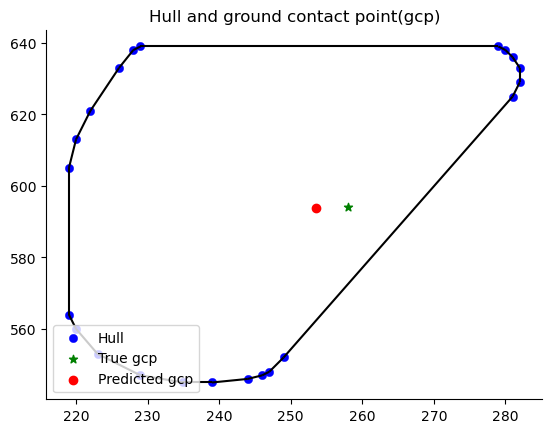

In [79]:
from utils import predict_and_plot
n = 9
hull = X[n]
gcp = y[n]
predicted_gcps = shifter.predict(X)
predict_and_plot(hull, gcp, None, predicted_gcps[n],)